<a href="https://colab.research.google.com/github/Shirley31415926/API_heatwave/blob/main/03C%20UK%20tem%26post%20with%20lag%20and%20forecast%20effect%202024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024 UK temperature data analysis：

The same-day average temperature has a certain positive effect on the number of posts, indicating that as the temperature rises, the public tends to post more about heatwaves. However, the overall explanatory power of the model (R² value) remains relatively low.
Further regression analysis incorporating lagged features (temperatures from one and two days prior) shows that the lagged temperatures are not statistically significant, with the same-day temperature remaining the primary explanatory variable.
This suggests that public responses to extreme weather are primarily immediate rather than based on the cumulative effects of past weather conditions.

In [ ]:
!pip install --upgrade atproto
!pip install pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.4/380.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.4/682.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


# Post Count vs. UK Temperature / time series & OLS regression & linear relationship

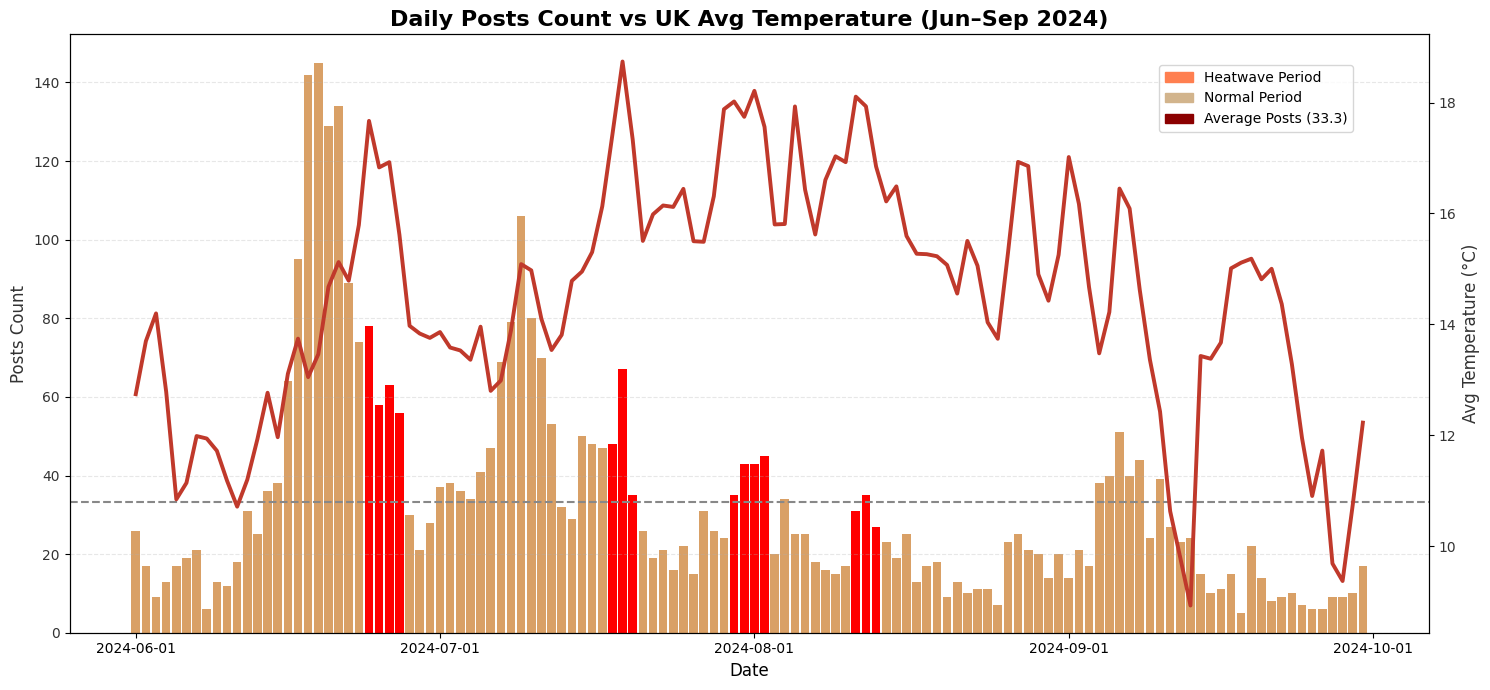

                            OLS Regression Results                            
Dep. Variable:            posts_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.331
Date:                Sat, 26 Apr 2025   Prob (F-statistic):              0.129
Time:                        20:05:32   Log-Likelihood:                -578.34
No. Observations:                 122   AIC:                             1161.
Df Residuals:                     120   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8018     17.557      0.387      0.6

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
from collections import defaultdict
import matplotlib.patches as mpatches

# 1. Load daily post frequency data
def load_posts_data(filepath):
    daily_counts = defaultdict(int)
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                post = json.loads(line)
                dt = datetime.strptime(post['created_at'], "%Y-%m-%dT%H:%M:%S.%f%z")
                date_str = dt.strftime("%Y-%m-%d")
                daily_counts[date_str] += 1
            except (json.JSONDecodeError, KeyError, ValueError):
                continue
    return daily_counts

# 2. Load temperature data (UK only)
def load_temperature_data(filepath, region_name):
    df_temp = pd.read_csv(filepath, parse_dates=['date'])
    df_temp.set_index('date', inplace=True)
    df_temp = df_temp.rename(columns={'avg_temp': region_name})
    df_temp = df_temp.sort_index()
    return df_temp.loc['2024-06-01':'2024-09-30']

# 3. File paths
posts_filepath = '/content/heat_posts2024_standardized.jsonl'
uk_filepath = '/content/uk_avg_temperature_2024_Jun-Oct.csv'

# 4. Process post data
daily_counts = load_posts_data(posts_filepath)
df_posts = pd.DataFrame.from_dict(daily_counts, orient='index', columns=['posts_count'])
df_posts.index = pd.to_datetime(df_posts.index)
full_date_range = pd.date_range(start='2024-06-01', end='2024-09-30', freq='D')
df_posts = df_posts.reindex(full_date_range, fill_value=0)
posts_avg = df_posts['posts_count'].mean()

# 5. Load UK temperature data
df_uk = load_temperature_data(uk_filepath, 'UK')

# 6. Official heatwave periods (UK definition for 2024)
heatwave_periods = [
    ("2024-06-24", "2024-06-27"),
    ("2024-07-18", "2024-07-20"),
    ("2024-07-30", "2024-08-02"),
    ("2024-08-11", "2024-08-13"),
]
heatwave_dates = set()
for start, end in heatwave_periods:
    heatwave_dates.update(pd.date_range(start=start, end=end))

# 7. Set bar colors: red for heatwave days, brown for normal days
bar_colors = ['#FF0000' if date in heatwave_dates else '#D9A066' for date in df_posts.index]

# 8. Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

# Bar chart: daily post counts
ax1.bar(df_posts.index, df_posts['posts_count'], color=bar_colors, label='Posts Count', width=0.85)
ax1.axhline(posts_avg, color='#888888', linestyle='--', linewidth=1.5, label=f'Avg Posts ({posts_avg:.1f})')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Posts Count', color='#333333', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#333333')

# Line chart: UK average temperature
ax2 = ax1.twinx()
ax2.plot(df_uk.index, df_uk['UK'], color='#C0392B', linewidth=2.8, label='UK Temp (°C)')
ax2.set_ylabel('Avg Temperature (°C)', color='#333333', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#333333')

# Title and legend
plt.title('Daily Posts Count vs UK Avg Temperature (Jun–Sep 2024)', fontsize=16, fontweight='bold')
heat_patch = mpatches.Patch(color='#FF7F50', label='Heatwave Period')
normal_patch = mpatches.Patch(color='#D2B48C', label='Normal Period')
avg_line = mpatches.Patch(color='darkred', label=f'Average Posts ({posts_avg:.1f})')
fig.legend(handles=[heat_patch, normal_patch, avg_line], loc='upper right', bbox_to_anchor=(0.91, 0.91))

# X-axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Grid and layout
ax1.grid(axis='y', linestyle='--', alpha=0.3)
fig.tight_layout()

# Show plot
plt.show()


import statsmodels.api as sm
df_merge = pd.merge(df_posts, df_uk, left_index=True, right_index=True, how='inner')
X = df_merge[['UK']]
X = sm.add_constant(X)
y = df_merge['posts_count']
model = sm.OLS(y, X).fit()
print(model.summary())

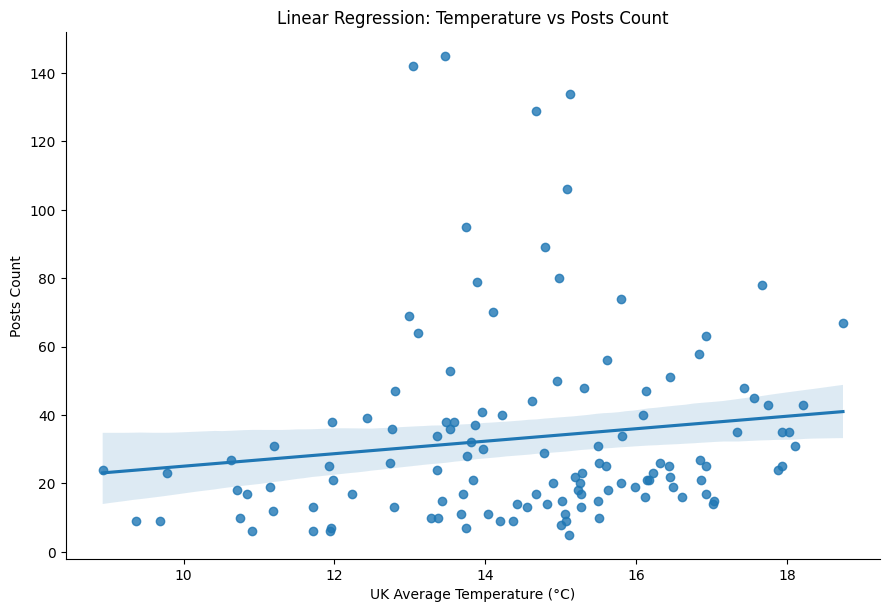

In [ ]:
df_merge_renamed = df_merge.rename(columns={'UK': 'avg_temp', 'posts_count': 'post_count'})
import seaborn as sns
sns.lmplot(x='avg_temp', y='post_count', data=df_merge_renamed, height=6, aspect=1.5, ci=95)
plt.xlabel('UK Average Temperature (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature vs Posts Count')
plt.show()

# Lag effect vs. Posts (Lead Analysis)

In [ ]:
import statsmodels.api as sm

def run_lagged_regression(df, temp_col='avg_temp', post_col='post_count', max_lag=2, min_samples=10):
    df_copy = df.copy()
    for lag in range(1, max_lag + 1):
        df_copy[f'{temp_col}_lag{lag}'] = df_copy[temp_col].shift(lag)

    feature_cols = [temp_col] + [f'{temp_col}_lag{lag}' for lag in range(1, max_lag + 1)]
    X = df_copy[feature_cols].dropna()
    y = df_copy.loc[X.index, post_col]

    if len(X) < min_samples:
        print(f"⚠️ {len(X)}  {min_samples} ")
        return None

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

lagged_model = run_lagged_regression(df_merge_renamed, temp_col='avg_temp', post_col='post_count', max_lag=2)

if lagged_model is not None:
    print(lagged_model.summary())


                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.992
Date:                Sat, 26 Apr 2025   Prob (F-statistic):              0.119
Time:                        20:09:22   Log-Likelihood:                -567.79
No. Observations:                 120   AIC:                             1144.
Df Residuals:                     116   BIC:                             1155.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.1867     19.236      1.153

             avg_temp  avg_temp_lag1  avg_temp_lag2
2024-06-01  12.739474            NaN            NaN
2024-06-02  13.697368      12.739474            NaN
2024-06-03  14.197368      13.697368      12.739474
2024-06-04  12.784211      14.197368      13.697368
2024-06-05  10.842105      12.784211      14.197368
2024-06-06  11.139474      10.842105      12.784211
2024-06-07  11.984211      11.139474      10.842105
2024-06-08  11.939474      11.984211      11.139474
2024-06-09  11.718421      11.939474      11.984211
2024-06-10  11.178947      11.718421      11.939474


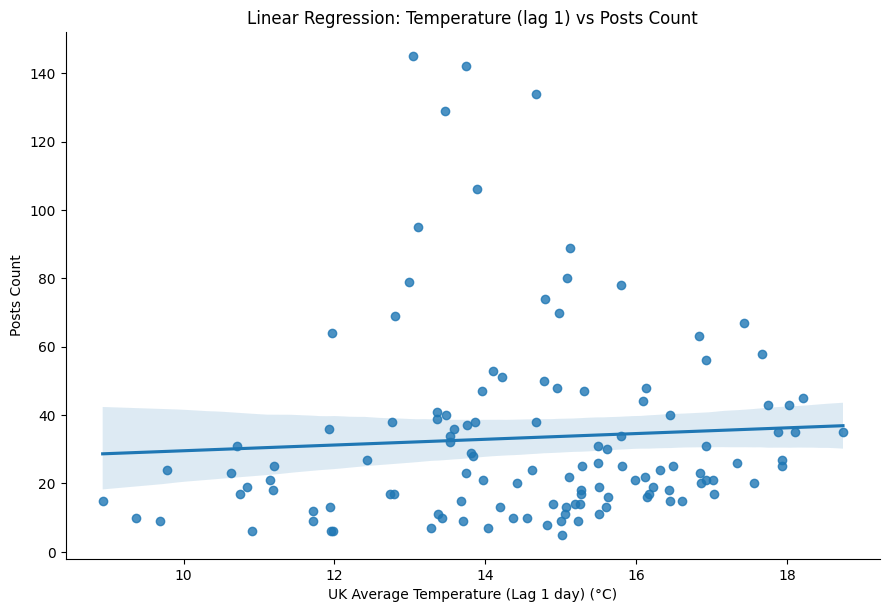

In [ ]:
for lag in range(1, 4):
    df_merge_renamed[f'avg_temp_lag{lag}'] = df_merge_renamed['avg_temp'].shift(lag)
print(df_merge_renamed[['avg_temp', 'avg_temp_lag1', 'avg_temp_lag2']].head(10))
import seaborn as sns

sns.lmplot(
    x='avg_temp_lag1',
    y='post_count',
    data=df_merge_renamed.dropna(subset=['avg_temp_lag1', 'post_count']),
    height=6,
    aspect=1.5,
    ci=95
)

plt.xlabel('UK Average Temperature (Lag 1 day) (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature (lag 1) vs Posts Count')
plt.show()


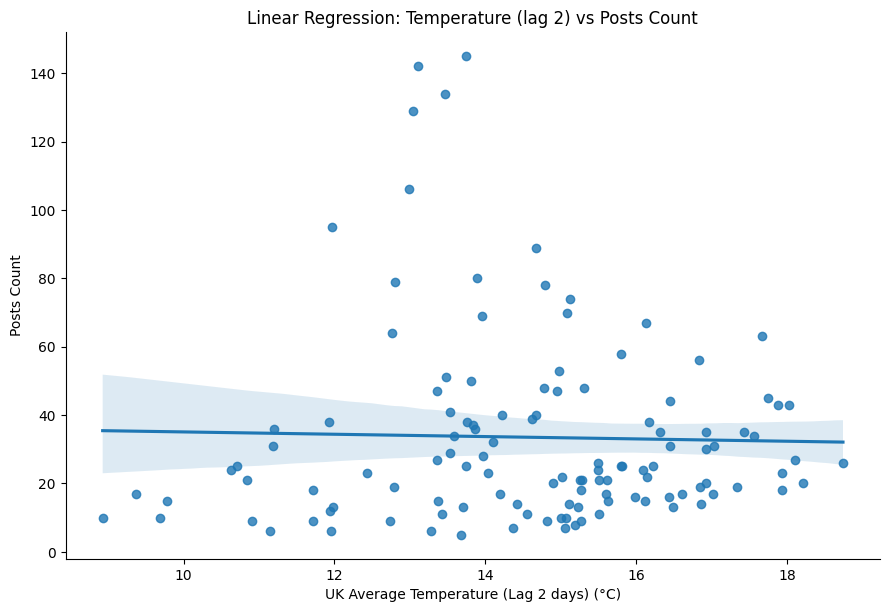

In [ ]:
sns.lmplot(
    x='avg_temp_lag2',
    y='post_count',
    data=df_merge_renamed.dropna(subset=['avg_temp_lag2', 'post_count']),
    height=6,
    aspect=1.5,
    ci=95
)

plt.xlabel('UK Average Temperature (Lag 2 days) (°C)')
plt.ylabel('Posts Count')
plt.title('Linear Regression: Temperature (lag 2) vs Posts Count')
plt.show()


# Forecast vs. Posts


In [ ]:
import statsmodels.api as sm

df_lead = df_merge_renamed.copy()
df_lead['avg_temp_lead1'] = df_lead['avg_temp'].shift(-1)
df_lead['avg_temp_lead2'] = df_lead['avg_temp'].shift(-2)

df_lead_clean = df_lead.dropna(subset=['avg_temp', 'avg_temp_lead1', 'avg_temp_lead2', 'post_count'])

X = df_lead_clean[['avg_temp', 'avg_temp_lead1', 'avg_temp_lead2']]
X = sm.add_constant(X)
y = df_lead_clean['post_count']

model_pred = sm.OLS(y, X).fit()
print(model_pred.summary())

                            OLS Regression Results                            
Dep. Variable:             post_count   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.304
Date:                Sat, 26 Apr 2025   Prob (F-statistic):              0.277
Time:                        20:16:32   Log-Likelihood:                -568.50
No. Observations:                 120   AIC:                             1145.
Df Residuals:                     116   BIC:                             1156.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0655     19.350      0.